In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#load
data = pd.read_csv("resources/cn7050data.csv",encoding='latin-1',names=["sentiment","text"])

data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


sentiment    0
text         0
dtype: int64
sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64
<class 'pandas.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   sentiment  4846 non-null   str  
 1   text       4846 non-null   str  
dtypes: str(2)
memory usage: 717.4 KB


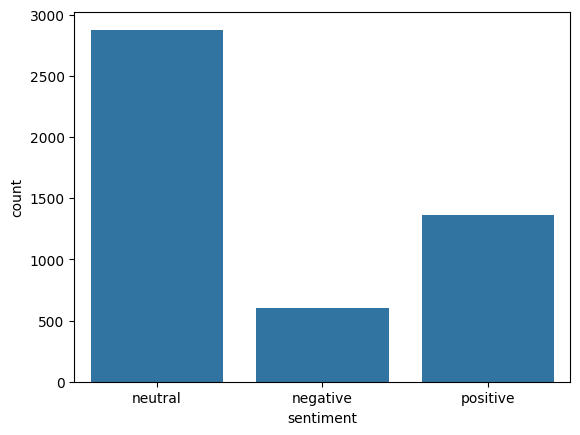

In [3]:
print(data.isnull().sum())
print(data.value_counts("sentiment"))
sns.countplot(x="sentiment",data=data)
data.info()

In [4]:
data.value_counts("sentiment")

sentiment
neutral     2879
positive    1363
negative     604
Name: count, dtype: int64

In [5]:
print("before removing duplicates:", data.shape)
print(data[data.duplicated(subset=["sentiment","text"],keep=False)])
data = data.drop_duplicates()
data=data.reset_index(drop=True)
print("after removing duplicates:", data.shape)
data[data.duplicated(subset=["sentiment","text"],keep=False)]

before removing duplicates: (4846, 2)
     sentiment                                               text
1098   neutral  The issuer is solely responsible for the conte...
1099   neutral  The issuer is solely responsible for the conte...
1415   neutral  The report profiles 614 companies including ma...
1416   neutral  The report profiles 614 companies including ma...
2395   neutral  Ahlstrom 's share is quoted on the NASDAQ OMX ...
2396   neutral  Ahlstrom 's share is quoted on the NASDAQ OMX ...
2566   neutral  SSH Communications Security Corporation is hea...
2567   neutral  SSH Communications Security Corporation is hea...
3093   neutral  Proha Plc ( Euronext :7327 ) announced today (...
3094   neutral  Proha Plc ( Euronext :7327 ) announced today (...
3205   neutral  The company serves customers in various indust...
3206   neutral  The company serves customers in various indust...
after removing duplicates: (4840, 2)


,sentiment,text


In [6]:
# lowercase all the text. probabely not needed but just to be sure
data['sentiment'] = data['sentiment'].str.lower()

# Sampling
**'stratify'** sampling to ensure each split has the same proportion of positive/negative/neutral labels.
neutral     2879
positive    1363
negative     604

we are going to use an 80% Train, 10% Validation, 10% Test split.

named: train / val/ test

In [7]:
train_df,temp_df = train_test_split(data, test_size=0.2, random_state=13,stratify=data["sentiment"])
val_df,test_df = train_test_split(temp_df, test_size=0.5, random_state=13,stratify=temp_df["sentiment"])

print(f"Training : {len(train_df)} rows")
print(f"Validation : {len(val_df)} rows")
print(f"Testing : {len(test_df)} rows")

Training : 3872 rows
Validation : 484 rows
Testing : 484 rows


## 1- FinBERT Baseline
We will use the hugging face transformers libraries to call :

1- ProsusAI/finbert

2- bert-base-uncased

In [8]:
from transformers import pipeline
import torch
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,f1_score
from tqdm.auto import tqdm

# I wanted to use the pretrained model on the train data but we probabely do not need it because we will compare the test dataset.
# train_text=train_df["text"].tolist()
# train_labels=train_df["sentiment"].tolist()

# test data
test_texts=test_df["text"].tolist()
test_labels=test_df["sentiment"].tolist()



In [9]:
finbert_classifier=pipeline("text-classification", model="ProsusAI/finbert",device=-1)

print("Running FineBert predictions...")
# model=finbert_classifier(test_texts, truncation=True, max_length=512) # This line is redundant as we do it in the loop/variable below

# Get both labels and scores
results = finbert_classifier(test_texts, truncation=True, max_length=512)
finbert_preds_labels = [result['label'] for result in results]
finbert_preds_scores = [result['score'] for result in results] 

finebert_res=pd.DataFrame({"text":test_texts,"true_label":test_labels,"pred_label":finbert_preds_labels})

#we use the result of the model trained on he test dataset to see how succesful it is to predict the sentiment.
# the metrics:

print(classification_report(finebert_res['true_label'], finebert_res['pred_label']))
print(f"accuracy: {accuracy_score(finebert_res['true_label'], finebert_res['pred_label'])}")
print(f"f1 score: {f1_score(finebert_res['true_label'], finebert_res['pred_label'],average='weighted')}")
print(f"confusion matrix:\n{confusion_matrix(finebert_res['true_label'], finebert_res['pred_label'])}")

# Dataframe with the results
finbert_res_df=pd.DataFrame({
    "text":test_texts,
    "true_label":test_labels, 
    "pred_label":finbert_preds_labels,
    "score": [round(s, 4) for s in finbert_preds_scores]
})

finbert_res_df.head()

/Users/Mehr/Desktop/code/26/Mar/assignment/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Running FineBert predictions...
              precision    recall  f1-score   support

    negative       0.83      0.93      0.88        61
     neutral       0.95      0.88      0.92       287
    positive       0.81      0.90      0.85       136

    accuracy                           0.89       484
   macro avg       0.86      0.90      0.88       484
weighted avg       0.90      0.89      0.89       484

accuracy: 0.8925619834710744
f1 score: 0.8938091178793657
confusion matrix:
[[ 57   1   3]
 [  9 253  25]
 [  3  11 122]]


,text,true_label,pred_label,score
0,Ingen is an established medical device manufac...,neutral,positive,0.5894
1,Russian officials inspected the damage and gav...,neutral,neutral,0.7964
2,"A state program has been worked out , legal pr...",neutral,neutral,0.7616
3,"Mr Ashley , deputy executive chairman of Sport...",neutral,neutral,0.9475
4,"EBIT excluding non-recurring items , totalled ...",positive,positive,0.9526


We see the model **accuracy** is 89% on test data.


## 2- BERT Baseline

Now we load **bert-base-uncased** for sequence classification.

In [10]:
bert_uncased=pipeline("text-classification", model="bert-base-uncased",device=-1)

print("Running bert-uncased predictions...")
bert_preds_raw = [result['label'] for result in tqdm(bert_uncased(test_texts, truncation=True, max_length=512))]

bert_uncased_results=bert_uncased(test_texts, truncation=True, max_length=512)

label_mapping = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}
bert_preds = [label_mapping[pred] for pred in bert_preds_raw]


print(f"Accuracy: {accuracy_score(test_labels, bert_preds):.4f}")
print(f"Macro F1: {f1_score(test_labels, bert_preds, average='macro'):.4f}")
print("Per-Class Metrics:")
print(classification_report(test_labels, bert_preds, zero_division=0))


bert_uncased_preds_labels = [result['label'] for result in bert_uncased_results]
bert_uncased_preds_scores = [result['score'] for result in bert_uncased_results] 

bert_uncased_res_df=pd.DataFrame({
    "text":test_texts,
    "true_label":test_labels, 
    "pred_label":bert_uncased_preds_labels,
    "score": [round(s, 4) for s in bert_uncased_preds_scores]
})

bert_uncased_res_df.head()


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Running bert-uncased predictions...


  0%|          | 0/484 [00:00<?, ?it/s]

Accuracy: 0.5083
Macro F1: 0.2589
Per-Class Metrics:
              precision    recall  f1-score   support

    negative       0.08      0.10      0.09        61
     neutral       0.58      0.84      0.69       287
    positive       0.00      0.00      0.00       136

    accuracy                           0.51       484
   macro avg       0.22      0.31      0.26       484
weighted avg       0.36      0.51      0.42       484



,text,true_label,pred_label,score
0,Ingen is an established medical device manufac...,neutral,LABEL_1,0.5282
1,Russian officials inspected the damage and gav...,neutral,LABEL_0,0.5130
2,"A state program has been worked out , legal pr...",neutral,LABEL_1,0.5292
3,"Mr Ashley , deputy executive chairman of Sport...",neutral,LABEL_0,0.5009
4,"EBIT excluding non-recurring items , totalled ...",positive,LABEL_1,0.5355


,Model,Accuracy,F1 Score (Weighted)
0,ProsusAI/finbert,0.892562,0.893809
1,bert-base-uncased,0.508264,0.418069


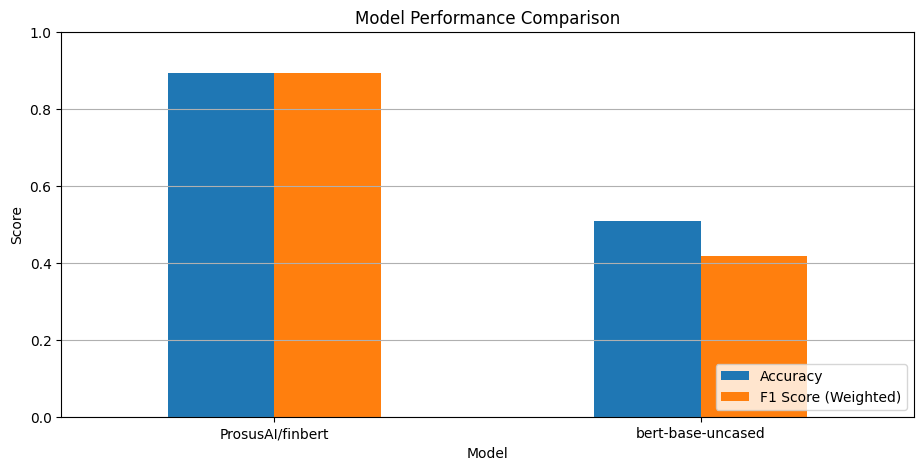

In [11]:
import numpy as np

# Collect metrics for comparison
model_metrics = []

# FinBERT Metrics
finbert_acc = accuracy_score(test_labels, finbert_preds_labels)
finbert_f1 = f1_score(test_labels, finbert_preds_labels, average='weighted')
model_metrics.append({
    'Model': 'ProsusAI/finbert',
    'Accuracy': finbert_acc,
    'F1 Score (Weighted)': finbert_f1
})

# BERT Uncased Metrics
bert_acc = accuracy_score(test_labels, bert_preds)
bert_f1 = f1_score(test_labels, bert_preds, average='weighted')
model_metrics.append({
    'Model': 'bert-base-uncased',
    'Accuracy': bert_acc,
    'F1 Score (Weighted)': bert_f1
})

#  comparison DataFrame
comparison_df = pd.DataFrame(model_metrics)
display(comparison_df)

#  grouped bar chart using Pandas
comparison_df.set_index('Model').plot(kind='bar', figsize=(11, 5))

plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.xticks(rotation=0) # Keep labels horizontal
plt.show()

## Discussion

We can see the **Finbert** predicts much better than the **bert-uncased** model. This comparison is before fine tuning.



## Fine-Tuning the Models

In [12]:
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer


label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
train_df['label'] = train_df['sentiment'].map(label2id)
test_df['label'] = test_df['sentiment'].map(label2id)
val_df['label'] = val_df['sentiment'].map(label2id)

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

MODEL_NAME_BERT= "bert-base-uncased"
MODEL_NAME_FINBERT= "ProsusAI/finbert"
print(f"Downloading/Loading Tokenizer for {MODEL_NAME_BERT}...")
tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_NAME_BERT)
print(f"Downloading/Loading Tokenizer for {MODEL_NAME_FINBERT}...")
tokenizer_finbert = AutoTokenizer.from_pretrained(MODEL_NAME_FINBERT)



# here we tokenize the text data for the BERT model. 
# We set truncation to True to ensure that texts 
# longer than the model's maximum input length are truncated, 
# and we set padding to "max_length" to pad shorter texts to the maximum length.
# The max_length is set to 128, which is a common choice for BERT-based models.
def tokenize_function_bert(examples):
    return tokenizer_bert(examples["text"], truncation=True, padding="max_length", max_length=128)

def tokenize_function_finbert(examples):
    return tokenizer_finbert(examples["text"], truncation=True, padding="max_length", max_length=128)
# here we map the tokenization on all the threee datasets
tokenized_train_bert = train_dataset.map(tokenize_function_bert, batched=True)
tokenized_val_bert = val_dataset.map(tokenize_function_bert, batched=True)
tokenized_test_bert = test_dataset.map(tokenize_function_bert, batched=True)

tokenized_train_finbert = train_dataset.map(tokenize_function_finbert, batched=True)
tokenized_val_finbert = val_dataset.map(tokenize_function_finbert, batched=True)
tokenized_test_finbert = test_dataset.map(tokenize_function_finbert, batched=True)


Downloading/Loading Tokenizer for bert-base-uncased...
Downloading/Loading Tokenizer for ProsusAI/finbert...


/Users/Mehr/Desktop/code/26/Mar/assignment/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/3872 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Map:   0%|          | 0/3872 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

Map:   0%|          | 0/484 [00:00<?, ? examples/s]

## Metrics for the modesl

In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    macro_f1= f1_score(labels, predictions, average='macro')
    per_class_f1= f1_score(labels, predictions, average=None)
    return {
        'accuracy': acc,
        'macro_f1': macro_f1,
        'fq1_|negative': per_class_f1[0],
        'fq1_|neutral': per_class_f1[1],
        'fq1_|positive': per_class_f1[2]
    }

## Load Models and Train

## Bert

In [ ]:
import logging
import warnings

# Suppress the specific transformers warning
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", message=".*beta.*renamed internally to.*bias.*")
warnings.filterwarnings("ignore", message=".*gamma.*renamed internally to.*weight.*")
print(f"Downloading/Loading Model {MODEL_NAME_BERT}...")

# Check for CUDA (GPU), then MPS, then default to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# num_layer=3 is used to fine-tune only the last 3 layers of the BERT model.
model_bert=AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME_BERT, 
    num_labels=3, 
    id2label=id2label, 
    label2id=label2id,
    ignore_mismatched_sizes=True
    )
model_bert.to(device)

training_args_bert = TrainingArguments(
    output_dir="./bert_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_strategy="epoch",
    # use_mps_device is specifically for MPS, Trainer handles CUDA automatically if the model is on cuda
    use_mps_device=True if device.type == "mps" else False 
)
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=tokenized_train_bert,
    eval_dataset=tokenized_val_bert,
    compute_metrics=compute_metrics
)

print("Starting BERT fine-tuning...")

trainer_bert.train()
print("\nEvaluating on Test Set...")


test_results_bert = trainer_bert.predict(tokenized_test_bert)
predictions_bert = np.argmax(test_results_bert.predictions, axis=-1)
test_labels_bert = tokenized_test_bert["label"]

print("\nClassification Report (Contains Per-Class F1 and Macro F1):")
print(classification_report(test_labels_bert, predictions_bert, target_names=['negative', 'neutral', 'positive']))

# Plot
cm=confusion_matrix(test_labels_bert, predictions_bert)
plt.figure(figsize=(10, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix for BERT Base Uncased')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

save_directory_bert=f"./fine_tuned_{MODEL_NAME_BERT.replace('/', '_')}"
print(f"Saving model to {save_directory_bert}...")

trainer_bert.save_model(save_directory_bert)
tokenizer_bert.save_pretrained(save_directory_bert)
print("Model saved successfully!")

Downloading/Loading Model bert-base-uncased...
Using device: mps


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Starting BERT fine-tuning...


  0%|          | 0/726 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Loading the model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Loading the saved model
my_model = AutoModelForSequenceClassification.from_pretrained("./my_fine_tuned_bert-base-uncased")
my_tokenizer = AutoTokenizer.from_pretrained("./my_fine_tuned_bert-base-uncased")

# Pipeline
from transformers import pipeline
my_classifier = pipeline("text-classification", model=my_model, tokenizer=my_tokenizer)

print(my_classifier("I got a NVDIA's share three months ago but now i am not happy about it. hahaha"))
